# MG2 Convergence Testing

This notebook provides the capability to make temporal convergence plots of the MG2 microphysics. While the testing itself is not fully automated, this notebook produces plots and statistics that make it easier to determine the degree to which MG2 converges at approximately first order.

This module requires a few dependencies (listed in the [Import statements](#import-statements) section below), as well as a compatible data file. Such a file should be a history file produced by EAM or CAM, or a netCDF file containing data in the same format (e.g. dimension names and order, same units for variables, and so on). This file should contain all variables used as input to the MG2 microphysics, each in all caps and prefixed with `MG2IN_`. E.g. there will be a `MG2IN_T` variable, an `MG2IN_Q` variable, and so on. Aerosol-related variables `RNDST` and `NACON` have an extra dimension of size four, which is handled using number suffixes rather than by adding a dimension to the netCDF file. E.g. the variables `MG2IN_RNDST1` through `MG2IN_RNDST4` should be present. For a full list of input variables, see the [Initialization](#initialization) code below.

## Import statements<a id="import-statements"></a>

Note that in addition to the standard Jupyter dependencies, the netCDF4 python interface is used to run this

In [1]:
# Dependencies of this notebook.
import numpy             as np
import os
import pycurl

# MG2 module (created with f2py)
import mg2

# Put plots in the notebook
%matplotlib inline

## Initialization <a id="initialization"></a>

Note that the `HIST_FILE_NAME` must point to a properly formatted netCDF data file with the expected inputs. The `mgncol` variable does not affect the results, but can be tuned to generate plots faster. This value represents the number of columns that can be fed into MG2 at once, and generally represents a tradeoff between vectorization (more columns is better, at least up to a point) and effective cache usage (more columns is worse).

Note that currently the `total_columns` (see below) must be a multiple of `mgncol`.

In [2]:
HIST_FILE_NAME = "MG2_data_collection.cam.h1.0001-01-06-00000.nc"
HIST_URL = "https://drive.google.com/a/uw.edu/file/d/1HIARthNbpvxo3EAEQn1MK0aANXgYJOUP/view?usp=drive_web"
if not os.path.isfile(HIST_FILE_NAME):
    with open(HIST_FILE_NAME, 'wb') as f:
        c = pycurl.Curl()
        c.setopt(c.URL, HIST_URL)
        c.setopt(c.WRITEDATA, f)
        print('Downloading', HIST_FILE_NAME, '...', end='')
        c.perform()
        c.close()
        print('Done')

mgncol = 128

In [3]:
# Construct the convergence test object
ctest = mg2.convergence_test(HIST_FILE_NAME, mgncol)

## Main loop

This loop runs MG2 on a designated number of columns using a range of time step sizes, and creates the data arrays that will be plotted (or otherwise used). At the end of the run, the 2-norm estimate of error for each column will be placed in the `norms` variable, which is a dictionary indexed by variable name, containing arrays of estimated errors at particular columns and timestep sizes.

For instance, the 2-norm of error in variable `Q`, in column `c`, for the `i+1`-th timestep in the `timesteps` array, will be located at `norms['Q'][c,i]`.

In [4]:
# Total number of columns to use in plots.
total_columns = 256

# Timesteps to run out (the data points in the plot).
# Must divide final_time exactly (currently not tolerant of floating-point error).
timesteps = np.array([0.25, 1., 2., 5., 10., 15., 30., 60., 75., 100., 150., 300.])

# Initialize the convergence tests
ctest.initialize(total_columns, timesteps)

In [5]:
# Run the convergence tests
ctest.run_tests()

Starting timestep = 0.25
Starting timestep = 1.0
Starting timestep = 2.0
Starting timestep = 5.0
Starting timestep = 10.0
Starting timestep = 15.0
Starting timestep = 30.0
Starting timestep = 60.0
Starting timestep = 75.0
Starting timestep = 100.0
Starting timestep = 150.0
Starting timestep = 300.0


## Statistical Convergence Plots

This function provides the ability to track the convergence of a particular variable. In order to do this, we need to collapse the vector of errors across all columns into a single number. This is done by finding the error at a given percentile (e.g. the 50th percentile is the median error).

Estimated slope for percentile 100.0 is 0.8470232653691256.
Estimated slope for percentile 90.0 is 1.1091931700997566.
Estimated slope for percentile 50.0 is 1.0533462370879123.


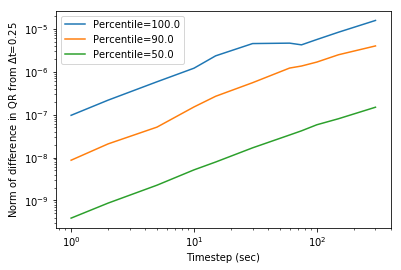

In [6]:
ctest.plot_variable_convergence("QR", (100., 90., 50.))

## Column-tracking Convergence Plots

Rather than tracking errors at a given percentile in each timestep, we can instead use percentiles to find a set of columns at *one* timestep, and then produce convergence plots specific to that column.

Estimated slope for percentile 100.0 is 0.6314135358440535.
Estimated slope for percentile 90.0 is 1.1185331576188706.
Estimated slope for percentile 50.0 is 1.0947399993709788.


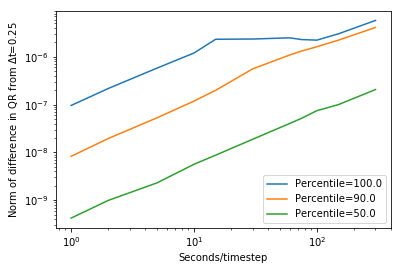

In [7]:
ctest.plot_column_variable_convergence("QR", (100., 90., 50.), 5.)

Estimated slope for percentile 100.0 is 1.4246558055414065.
Estimated slope for percentile 90.0 is 0.870089456448782.
Estimated slope for percentile 50.0 is 1.0005107452111635.


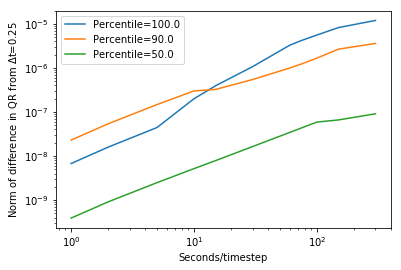

In [8]:
ctest.plot_column_variable_convergence("QR", (100., 90., 50.), 100.)